In [1]:
from osgeo import gdal
import sklearn as sk
# import input_test
import input_test_inter2
import numpy as np
import tensorflow as tf
import time
from sklearn.metrics import confusion_matrix

In [2]:
bands=5
n_classes = 3
dataset= input_test_inter2.read_data_sets('/media/gitecx/Nuevo vol/ASIAlac/asialac/ASIALaC/Dataset_path/Training','/media/gitecx/Nuevo vol/ASIAlac/asialac/ASIALaC/Dataset_path/Validation',5,n_clases=n_classes)  

191048
47760
83412


In [3]:
%matplotlib 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using matplotlib backend: Qt4Agg


In [4]:
#/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.9_epsilon_1e-08_bath_500_ep_22.ckpt
batch_size = 300
dropout = 0.75
epsilon=1e-08
epochs=11
c1=128
c2=256
fc=1024
b1=128
b2=256
b3=1024
decay=0.96
learning_rate = 0.0001

In [5]:
def accuracy2(path,size,select):
    position=[]
    if select:
        matrix = test_model(path,size)
    else:
        matrix,position = validation_model(path,size)
        
        
    labels= ["Otros",
         "Bosques y Areas seminaturales","Superficies de Agua"]
    import seaborn as sns; sns.set()
    f, ax = plt.subplots(figsize=(15, 8))
    ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
    f.tight_layout()
    return position

In [6]:
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='VALID'),b))

def max_pool(img):
    return tf.nn.max_pool(img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def conv_net2(images,w,b,_dropout):
    # Conv 1
    conv1 = conv2d(images,w['wc1'], b['bc1'])    
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)
    
    #Conv 2
    conv2 = conv2d(conv1, w['wc2'], b['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2)
    
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, w['wd1'].get_shape().as_list()[0]]) 
        
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, w['wd1']),b['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, w['out']),b['out'])
    return out


In [7]:
keep_prob = tf.placeholder(tf.float32) 
# tf Graph input
x = tf.placeholder(tf.float32,[None,20,20,bands])
y = tf.placeholder("float", [None, n_classes])
    
weights = {  
   # 5x5 conv, 7 input, 128 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, bands, c1])), 
     # 5x5 conv, 128 inputs, 256 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, c1, c2])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*c2, fc])), 
        # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([fc, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([b1])),
    'bc2': tf.Variable(tf.random_normal([b2])),
    'bd1': tf.Variable(tf.random_normal([b3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
    }
saver = tf.train.Saver()

pred = conv_net2(x,weights,biases, keep_prob) 
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=decay,  epsilon=epsilon).minimize(cost)
#optimizer =tf.train.AdadeltaOptimizer(learning_rate=learning_rate,rho=decay, epsilon=1e-08).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.initialize_all_variables()
saver = tf.train.Saver()

In [8]:
def continue_training (model_path,size, size_text, ep):
    from sklearn.metrics import confusion_matrix
    with tf.Session() as sess :
        saver.restore(sess,model_path)
        print ("Model successfully restored")
        
#####################################################
#### Continue Training
#####################################################
        iters=((size/batch_size)*int(epochs))+1
        for i in range (1,iters):
            
            batch_xs, batch_ys,_ = dataset.train.next_batch(batch_size)
            # Fit training using batch data
            start_time = time.clock()
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
            if( i%int(size/batch_size)==0):
            
                epoch_time = time.clock()
                print "time this epoch=", (epoch_time-start_time)
                correct2 =0
                y_p = tf.argmax(pred,1)
                step = 1
                y_true_a = 0
                y_pred_a = 0
                limit = size_text/batch_size
            
######################################################
###   Continue_Testing 
######################################################
                while step <= limit:
                    t_batch_xs, t_batch_ys,_ = dataset.test.next_batch(batch_size)
                    predictions = sess.run([correct_pred], feed_dict={x: t_batch_xs,
                                                                      y: t_batch_ys, keep_prob: 1.})
                    prediction  = tf.argmax(pred,1)
                    y_true = np.argmax(t_batch_ys,1)
                    labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys,
                                                        keep_prob: 1.}, session=sess)    
                    
                    if (step ==1):
                        y_true_a+=y_true
                        y_pred_a+=labels              
                    else:
                        y_true_a = np.concatenate((y_true_a, y_true))
                        y_pred_a = np.concatenate((y_pred_a, labels))
                    step+=1

        
                a=confusion_matrix(y_true_a, y_pred_a)            
                
                accuaracy,matrix=precision_measure(a)
                print ("test accuracy "+str(accuaracy))

        np.set_printoptions(precision=3, suppress=True)
        print (a)
        print (matrix)
        model= "/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5"+"/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_bath_"+str(batch_size)+"_ep_"+str(ep)+".ckpt"
        save_path = saver.save(sess, model)
        print ("model saved")
        print (model)
        sess.close()

In [9]:
def precision_measure (a2):
    pro=0
    b2=a2.astype(float)

    for i in range(n_classes):
        a1=b2[i]
        sum_a1=np.sum(b2[i])
        if(sum_a1 > 0):
            b2[i]=a1/sum_a1
    #print ('Matrix de confusion con medidas de desempeño')
    np.set_printoptions(precision=3)
    for l in range (n_classes):
        if(b2[l][l]!=np.nan):
            pro+=b2[l][l]
        
    pro=pro/n_classes 
    return pro,b2

In [10]:
def test_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/batch_size
######################################################
###   Test 
######################################################
        while step <= limit:
            t_batch_xs, t_batch_ys,_ = dataset.test.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=labels              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, labels))
            step+=1

        print step
        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        accuaracy,matrix=precision_measure(a)
        
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)
        print (matrix)
        sess.close()
    return matrix

In [11]:
def validation_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/batch_size
        posicion=[]
######################################################
###   Test 
######################################################
        while step < limit:
            t_batch_xs, t_batch_ys,p = dataset.validation.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            pred_1 = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=pred_1              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, pred_1))
            step+=1
            
            for i in range(len(p)):
                xi=p[i].find('x=')
                
                xi=p[i].find('x=')
                yi=p[i].find('y=')
                z=p[i].find('Size')
                x0=p[i][xi+2:yi-1]
                y0=p[i][yi+2:z]

                posicion.append([[x0],[y0],pred_1[i]])
           
        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        print (a)
                       
        accuaracy,matrix=precision_measure(a)
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)        
        print (matrix)
        sess.close()
    return matrix,posicion

In [13]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sess:
    sess.run(init)
    print ("Start Train")     
    
# 191048
# 47760
#83412

##########################################################            
###   TRAIN
##########################################################
    iters=((191048/batch_size)*int(epochs))+1
    # Keep training until reach max iterations
    for i in range (1,iters): 
        
        batch_xs, batch_ys,_ = dataset.train.next_batch(batch_size)
        # Fit training using batch data

        start_time = time.clock()
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
        if(i%int(191048/batch_size)==0):
            
            epoch_time = time.clock()
            print "time this epoch=", (epoch_time-start_time)
            correct2 =0
            y_p = tf.argmax(pred,1)
            step = 1
            y_true_a = 0
            y_pred_a = 0
            limit = 47760/batch_size
######################################################
###   Test 
######################################################
            while step <= limit:
        
                t_batch_xs, t_batch_ys,_ = dataset.test.next_batch(batch_size)
                prediction  = tf.argmax(pred,1)
                y_true = np.argmax(t_batch_ys,1)
                labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
                
                if (step ==1):
                    y_true_a+=y_true
                    y_pred_a+=labels              
                else:
                    y_true_a = np.concatenate((y_true_a, y_true))
                    y_pred_a = np.concatenate((y_pred_a, labels))
                step+=1

            a=confusion_matrix(y_true_a, y_pred_a)            
            accuaracy,matrix=precision_measure(a)
            print ("test accuracy "+str(accuaracy))
            
#######################################################   
#   END TRAIN             
############################
#           %matplotlib
#           import matplotlib.pyplot as plt
#           l=np.arange(0.0, epochs-1, 1.)
#           plt.plot(val,l, 'r--') 
    print "Optimization Finished!"    
    model= "/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5"+"/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_Bathsize_"+str(batch_size)+".ckpt"
    np.set_printoptions(precision=3, suppress=True)
    print (a)
    print (matrix)
    save_path = saver.save(sess, model)
    print("Model saved in file: %s" % save_path)
    sess.close()        
        

Start Train
time this epoch= 0.067824
test accuracy 0.69572327044
time this epoch= 0.069416
test accuracy 0.754356099047
time this epoch= 0.07144
test accuracy 0.790661499806
time this epoch= 0.071146
test accuracy 0.805589879725
time this epoch= 0.0691890000001
test accuracy 0.81135300834
time this epoch= 0.0717920000001
test accuracy 0.812346114564
time this epoch= 0.0701779999999
test accuracy 0.812065420786
time this epoch= 0.069932
test accuracy 0.814004818974
time this epoch= 0.069886
test accuracy 0.815264243579
time this epoch= 0.071558
test accuracy 0.815124663489
time this epoch= 0.076233
test accuracy 0.816526435049
Optimization Finished!
[[10835  3531  1532]
 [ 1880 12926  1093]
 [  168   547 15188]]
[[ 0.682  0.222  0.096]
 [ 0.118  0.813  0.069]
 [ 0.011  0.034  0.955]]
Model saved in file: /media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_300.ckpt


# Prueba con los datos de entrenamiento las primeras 11 epocas

In [14]:
#191048
#47760
#83412
accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_300.ckpt'
          ,47760,True)

Model successfully restored
160
sklearn martix
test accuracy 0.816513172959
[[ 0.682  0.222  0.097]
 [ 0.118  0.813  0.069]
 [ 0.011  0.034  0.955]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


[]

# Validacion epoca 11

In [12]:
#83412
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_300.ckpt'
          ,83412,False)

Model successfully restored
sklearn martix
[[23924 16267 24255]
 [  792 16652  1103]
 [   31     1    75]]
test accuracy 0.656662414479
[[ 0.371  0.252  0.376]
 [ 0.043  0.898  0.059]
 [ 0.29   0.009  0.701]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


TypeError: can only concatenate list (not "str") to list

In [21]:
p[0]
import io
with io.FileIO("/media/gitecx/Nuevo vol/ASIAlac/asialac/ASIALaC/Dataset_path/prueba.txt", "w") as file:
    for i in p:
        
        file.write(i[0][0]+" "+i[1][0]+" "+str(i[2])+"\n")
    file.close

In [12]:
continue_training ('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_300.ckpt'
,191048, 47760, 22)

Model successfully restored
time this epoch= 0.069317
test accuracy 0.822877835842
time this epoch= 0.0756
test accuracy 0.828875252329
time this epoch= 0.068926
test accuracy 0.836111895936
time this epoch= 0.073682
test accuracy 0.83695912747
time this epoch= 0.07107
test accuracy 0.839903257238
time this epoch= 0.0720289999999
test accuracy 0.839930006714
time this epoch= 0.287194
test accuracy 0.840929040715
time this epoch= 0.0704450000001
test accuracy 0.841253354028
time this epoch= 0.071964
test accuracy 0.843529474342
time this epoch= 0.071426
test accuracy 0.842922187858
time this epoch= 0.0692120000001
test accuracy 0.846121593291
[[12313  2893   694]
 [ 1606 13548   746]
 [  280  1121 14499]]
[[ 0.774  0.182  0.044]
 [ 0.101  0.852  0.047]
 [ 0.018  0.071  0.912]]
model saved
/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_300_ep_22.ckpt


# Prueba Epoca 22

Model successfully restored
160
sklearn martix
test accuracy 0.851727281119
[[ 0.808  0.156  0.036]
 [ 0.108  0.847  0.045]
 [ 0.014  0.086  0.9  ]]


[]

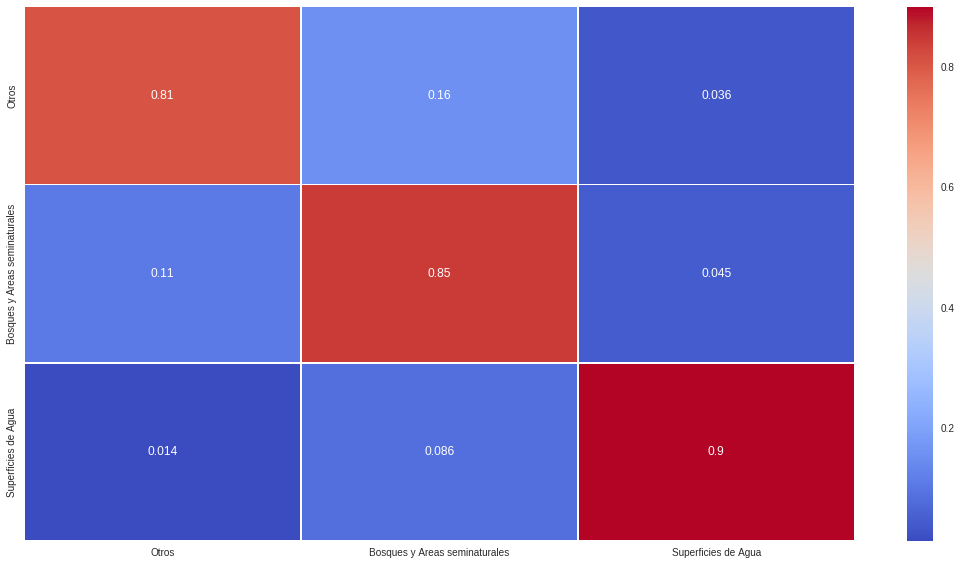

In [17]:
accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_300_ep_22.ckpt'
          ,47760,True)

# Validacion epoca 22

Model successfully restored
sklearn martix
[[25282 21991 17187]
 [ 3558 14668   308]
 [   25     5    76]]
test accuracy 0.633534579211
[[ 0.392  0.341  0.267]
 [ 0.192  0.791  0.017]
 [ 0.236  0.047  0.717]]


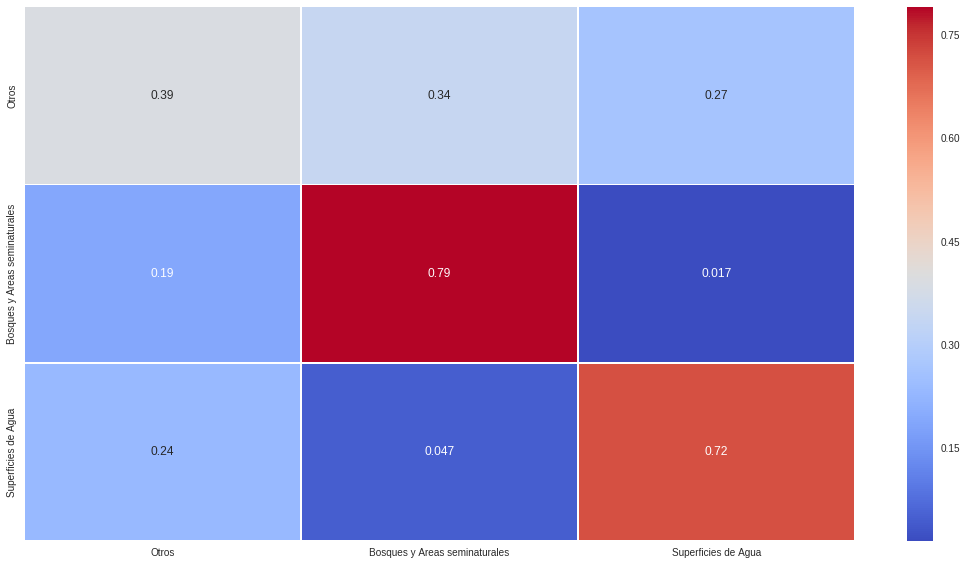

In [19]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_300_ep_22.ckpt'
          ,83412,False)

In [ ]:
continue_training ('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_cuencas_20x20_5/model_B_5_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_300_ep_22.ckpt'
,191048, 47760, 22)

Model successfully restored
time this epoch= 0.071525
test accuracy 0.853709744161
time this epoch= 0.075599
test accuracy 0.849811059296
time this epoch= 0.08493
